In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal

import sys
sys.path.insert(0,'..')
import specsens as ss

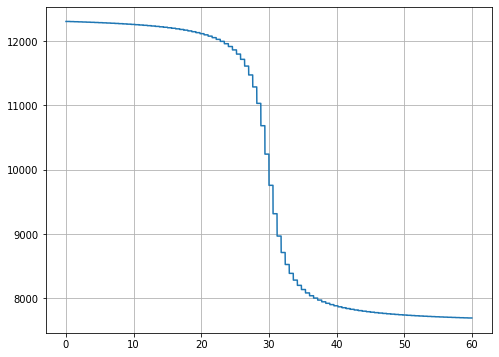

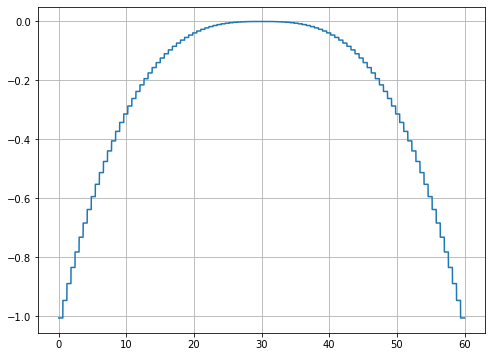

In [2]:
from scipy import constants


def get_relative_speed(t, l=1000.0, v=7660.0):
    # t -> time vector that starts by 0 and goes to whatever time you want (equally spaced)
    # l -> orthogonal distance of observer and object path in meters
    # v -> speed of object on its path in m/s

    # object -> thing that creates the signal (moving)
    # observer -> we / thing that receives the signal (stationary)

    # we will assume that the object will be closest to the oberserver at the half the time
    max_d = t[-1] * .5 * v

    # calculate objects position on its path at every time step
    x = max_d - t * v

    # calculate relative angle of observer and object at every time step
    # we will assume that the object is moving from right to left above the observer
    a = np.arctan2(x, l)

    # calculate realtive speed of object
    v = a / np.pi * 2. * v

    # calculate distance between object and observer
    d = np.sqrt(l**2. + x**2.)

    return v, d, max_d

def get_doppler(t, l=1000.0, v=7660.0, f0=450e5, f_sample=1e6, steps=1e3):
    
    # calculate relative speed and doppler shift using only 'steps' resultion
    t0 = np.linspace(0, int(t), steps, endpoint=False)
    v, d, max_d = get_relative_speed(t0, l, v)
    fd = v / constants.speed_of_light * f0
    p = -np.abs(d/max_d)**3
    
    # upscale to 't * f_sample' resolution
    t1 = np.linspace(0, int(t), int(t * f_sample), endpoint=False)
    fd = np.repeat(fd, int(t * f_sample / steps))
    p = np.repeat(p, int(t * f_sample / steps))
    
    return t1, fd, p

sample_freq = 1e5  # in Hz
length = 60.0  # in s
signal_strength = 0.0  # in dB
noise_strength = 0.0  # in dB

t, fc, p = get_doppler(t=length, # length of signal in seconds
                    l=30000.0, # distance in m
                    v=16000.0, # speed in m/s
                    f0=450e5, # acutal frequency of signal before down sapling to baseband
                    f_sample=sample_freq, # sample frequency after decimation
                    steps=100) # steps / resolution 

fc += 1e4 # add frequency offset in baseband

plt.figure(figsize=(8, 6))
plt.plot(t, fc)
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(t, p)
plt.grid()
plt.show()

Signal power: 1.94 dB
Noise power:  -0.00 dB
SNR:          1.94 dB
Num Samples:  6000000 
Freq Energy:  359683112.83
Time Energy:  5994718.55


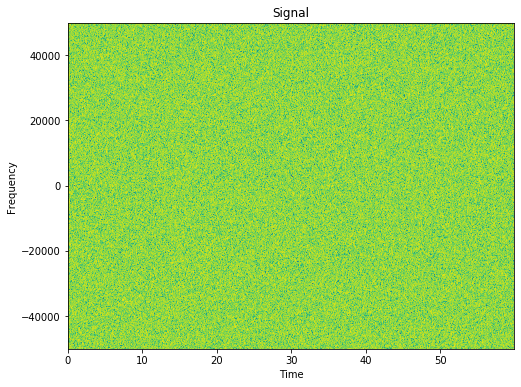

In [3]:
wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length)
sig = wm.get_very_silent(f_center=fc, power=p*100, dB=True)
sig += wm.get_very_silent(f_center=-1e4, power=1, dB=True)

wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)
noise = wgn.get_signal(power=noise_strength, dB=True)

assert wm.num_samples == wgn.num_samples  # ensure noise and signal have same length
num_samples = wm.num_samples

# both = sig + noise  # create actual signal ('both') comprising of signal and additive white gaussian noise (AWGN)
both = noise  # create actual signal ('both') comprising of signal and additive white gaussian noise (AWGN)

print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num Samples:  %d ' % (num_samples))

# Note, that Parseval's theorem holds
from scipy import fft
print("Freq Energy:  %.2f" % (np.sum(np.abs(fft.fft(both))**2)/sample_freq))
print("Time Energy:  %.2f" % (np.sum(np.abs(both)**2)))

sft = ss.Stft(n=1024, window='flattop')
f, t, x = sft.spectogram(both, sample_freq, normalized=True, dB=True)
plt.figure(figsize=(8, 6))
plt.pcolormesh(t,
               f,
               x,
               shading='flat',
               cmap='viridis',
               snap=True,
               vmin=np.min(x),
               vmax=np.max(x))
plt.title("Signal")
plt.xlabel("Time")
plt.ylabel("Frequency")
# plt.grid()
plt.show()

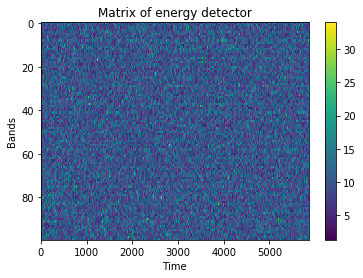

False Alarm: 0.01000
Threshold:   18.78312
Detection:   1.00000


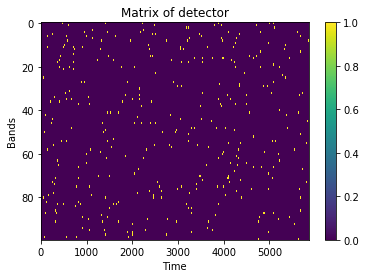

In [4]:
# Use the STFT to transform the signal into the frequency domain
nfft = 1024

bands = 100

sft = ss.Stft(n=nfft, window='box')
f, t, x = sft.spectogram(both, sample_freq, normalized=False, dB=False)

# Create a Frequency Energy Detector object
fed = ss.FreqEnergyDetector(num_bands=bands,
                            f_sample=sample_freq,
                            fft_len=nfft,
                            freqs=f)

# Compute the energy at every timestep
res = []
for i in range(len(t)):
    res.append(fed.detect(x[:, i]))
res = np.array(res)

# Plot result of energy detector 
ss.util_wide.plot_matrix(res, title='energy detector')

# Compute threshold and probability of false alarm
pfa = 0.01
thr = ss.chi2_stats.get_thr(noise_power=noise_strength,
                            pfa=pfa,
                            n=nfft // bands,
                            dB=True)
pd = ss.chi2_stats.get_pd(noise_power=noise_strength,
                           signal_power=0.,
                           thr=thr,
                            n=nfft // bands,
                            dB=True,
                            bands=bands)
print('False Alarm: %.5f' % (pfa))
print('Threshold:   %.5f' % (thr))
print('Detection:   %.5f' % (pd))

# Apply threshold to result of energy detector matrix
res = (res > thr) * np.full_like(res, 1.)

ss.util_wide.plot_matrix(res, title='detector')

# mats, factor = ss.util_wide.scale_matrix(mat, signal_length=1.024, band_width=1e4, fft_len=nfft)

# print('Simulation False Alarm: %.5f' % (ss.util_wide.get_pfa(res, mats)))
# print('Simulation Detection:   %.5f' % (ss.util_wide.get_pd(res, mats)))

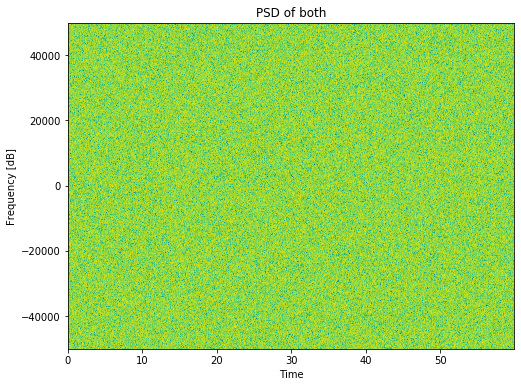

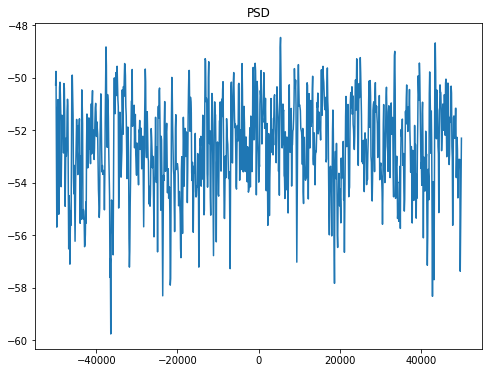

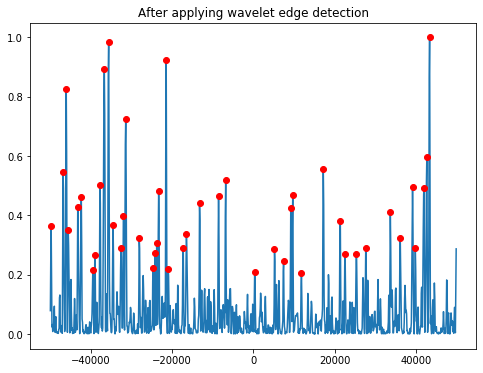

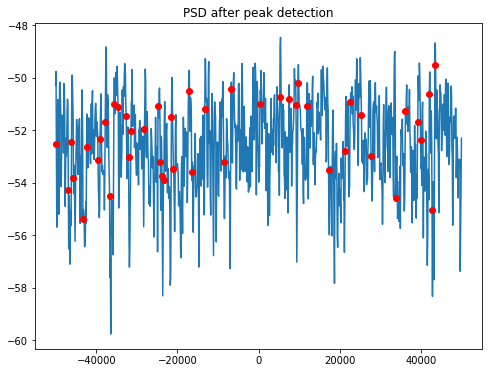

In [5]:
sft = ss.Stft(n=1024, window='flattop')
f, t, x = sft.spectogram(both, sample_freq, normalized=True, dB=True)

psd = ss.util_wide.psd_average(spectogram=x, start=2500, stop=2510)

prod, peak, peakf = ss.band_detect(psd,
                                   f,
                                   scale=2,
                                   min_height=0.2,
                                   min_freq=100)

# Plot the wideband signal in 2d
ss.plot2d(both,
          sample_freq,
          window='flattop',
          nfft=1024,
          dB=True,
          type='our',
          title='both')

plt.figure(figsize=(8, 6))
plt.title('PSD')
plt.plot(f, psd)
plt.show()

plt.figure(figsize=(8, 6))
plt.title('After applying wavelet edge detection')
plt.plot(f, prod)
plt.plot(peakf, prod[peak], 'ro')
plt.show()

plt.figure(figsize=(8, 6))
plt.title('PSD after peak detection')
plt.plot(f, psd)
plt.plot(peakf, psd[peak], 'ro')
plt.show()

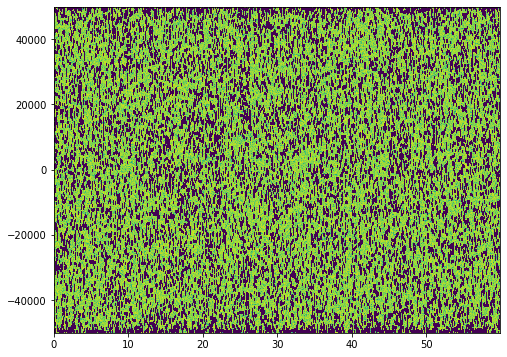

<Figure size 576x432 with 0 Axes>

In [6]:
# Use edge detection in spectrum in oder to detect spectrum areas of interest

# Number of fft bins
nfft=1024

# Fourier transform of signal
sft = ss.Stft(n=nfft, window='flattop')
f, t, x = sft.spectogram(both, sample_freq, normalized=False, dB=False)

# Variable Band Frequency Energy Detector
ved = ss.VariableBandFreqEnergyDetector(f_sample=sample_freq,
                                        fft_len=nfft,
                                        freqs=f,
                                        noise_power=noise_strength,
                                        pfa=0.1, 
                                        smooth=10., 
                                        scale=2, 
                                        min_height=0.2,
                                        min_freq=1e2)

# Empty overlay picture of edges in spectrum
res = np.empty(shape=(len(f), len(t)))
res[:] = np.nan

# Empty detection results
det = np.array([])

# # Do actual detection
# ps, peak, peakf, dics = ved.detect(x[:, 2500])

# plt.figure(figsize=(8, 6))
# plt.title('PSD')
# plt.plot(f, x)
# plt.plot(peakf, x[peak], 'ro')
# plt.show()

# plt.figure(figsize=(8, 6))
# plt.title('PSD')
# plt.plot(f, ps)
# plt.plot(peakf, ps[peak], 'ro')
# plt.show()

# Loop over spectrum and detect
for i, _ in enumerate(t):

    # Do actual detection
    ps, peak, peakf, dics = ved.detect(x[:, i])

    # Store edges in res
    res = ss.util_wide.store_pic(pic=res,
                                 x=i,
                                 y=peak,
                                 n=3,
                                 val=1.,
                                 minimum=0,
                                 maximum=len(f))

    # Store detection results in det
    det = np.append(det, dics)

# Plot spectrum and edges in one picture
plt.figure(figsize=(8, 6))
plt.pcolormesh(t,
               f,
               ss.util.dB_power(x),
               shading='flat',
               cmap='viridis',
               snap=True,
               vmin=np.min(ss.util.dB_power(x)),
               vmax=np.max(ss.util.dB_power(x)))
plt.pcolormesh(t, f, res, shading='flat', cmap='viridis', snap=True)
plt.show()

# Plot detection results
plt.figure(figsize=(8, 6))
for i, dic in enumerate(det):
    for j, d in enumerate(dic.items()):
        plt.plot(t[i], f[int(d[1][1])], 'k_')
        plt.plot(t[i], f[int(d[0])], 'k_', markeredgewidth=d[1][0] / 10)
        plt.plot(t[i], f[int(d[1][2])], 'k_')
plt.show()

# Print some channel stats
for j, d in enumerate(det[100].items()):
    print('--- Raw: ', det[100])
    print('Channel center freq: %.2f' % (d[0]))
    print('Energy in channel:   %.2f' % (d[1][0]))
    print('Channel upper freq:  %.2f' % (f[d[1][1]]))
    print('Channel lower freq:  %.2f' % (f[d[1][2]]))
    print('Channel width:       %.2f' % (d[1][3] * (f[0] - f[1])))

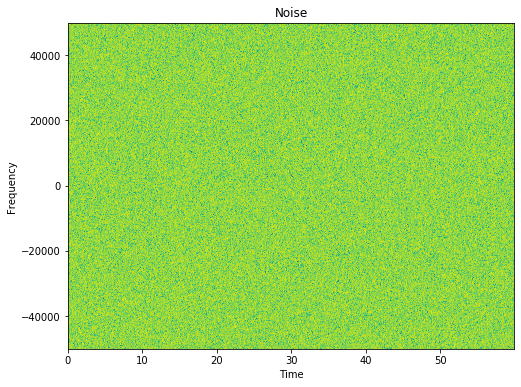

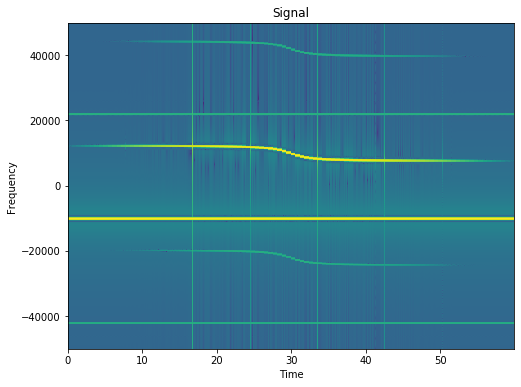

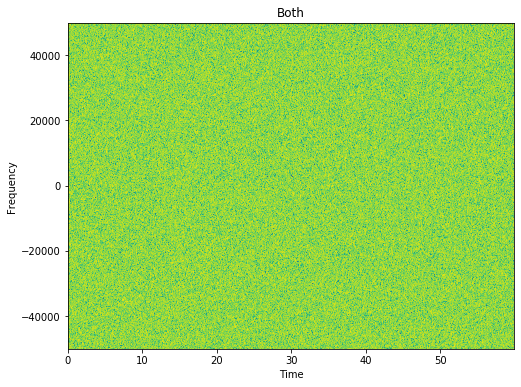

In [7]:
# Plot the spectogram our Short Time Fourier Transform
nfft = 1024

sft = ss.Stft(n=nfft, window='flattop')
f, t, x = sft.spectogram(noise, sample_freq, normalized=True, dB=True)
plt.figure(figsize=(8, 6))
plt.pcolormesh(t,
               f,
               x,
               shading='flat',
               cmap='viridis',
               snap=True,
               vmin=np.min(x),
               vmax=np.max(x))
plt.title("Noise")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

sft = ss.Stft(n=nfft, window='flattop')
f, t, x = sft.spectogram(sig, sample_freq, normalized=True, dB=True)
plt.figure(figsize=(8, 6))
plt.pcolormesh(t,
               f,
               x,
               shading='flat',
               cmap='viridis',
               snap=True,
               vmin=np.min(x),
               vmax=np.max(x))
plt.title("Signal")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

sft = ss.Stft(n=nfft, window='flattop')
f, t, x = sft.spectogram(both, sample_freq, normalized=True, dB=True)

plt.figure(figsize=(8, 6))
plt.pcolormesh(t,
               f,
               x,
               shading='flat',
               cmap='viridis',
               snap=True,
               vmin=np.min(x),
               vmax=np.max(x))
plt.title("Both")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

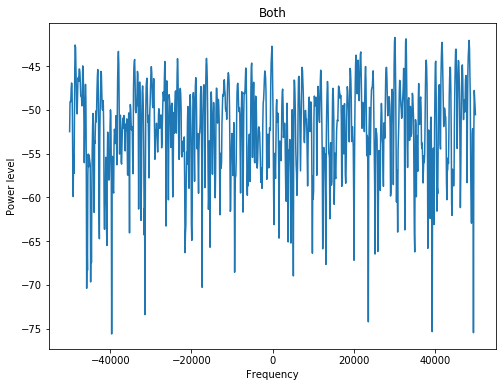

In [8]:
# Plot only 2nd FFT bin using our Short Time Fourier Transform

sft = ss.Stft(n=1024, window='flattop')
f, x = sft.stft(both[1024:2048], sample_freq, normalized=True, dB=True)

plt.figure(figsize=(8, 6))
plt.plot(f, x)
plt.title("Both")
plt.xlabel("Frequency")
plt.ylabel("Power level")
plt.show()

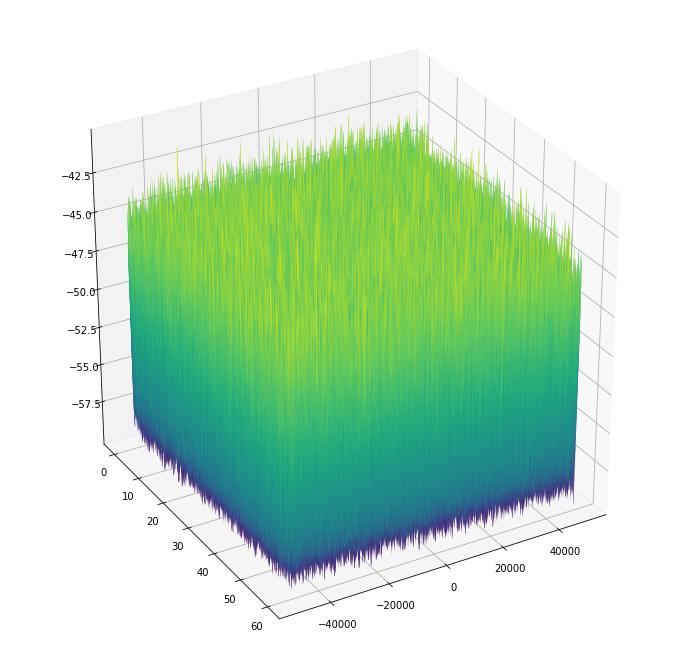

In [9]:
# Use out 3D Plot 
ss.plot3d(sig=both,
          f_sample=sample_freq,
          window='flattop',
          nfft=1024,
          clip=-60,
          smooth=.5,
          crop=None,
          elev=30,
          azim=60,
          type='our')